## NYC TLC Taxi Trip Data

Data is primarily from:
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Data source: [NYC TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), 
via [NYC Open Data](https://opendata.cityofnewyork.us/).  
© City of New York. Data made available under the NYC Open Data Terms of Use.



In [56]:
import pyarrow.parquet as pq
import pandas as pd

# Load parquet data
trips = pq.read_table('../data/raw/yellow_tripdata_2025-01.parquet')

# Convert to pandas DataFrame
df = trips.to_pandas()

In [57]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


In [58]:
# Load taxi_zone_lookup.csv
taxi_zone_lookup = pd.read_csv("../data/raw/taxi_zone_lookup.csv")

In [59]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [61]:
# Read .shp file
taxi_zones_shape = gpd.read_file("../data/raw/taxi_zones.shp")

In [62]:
taxi_zones_shape.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


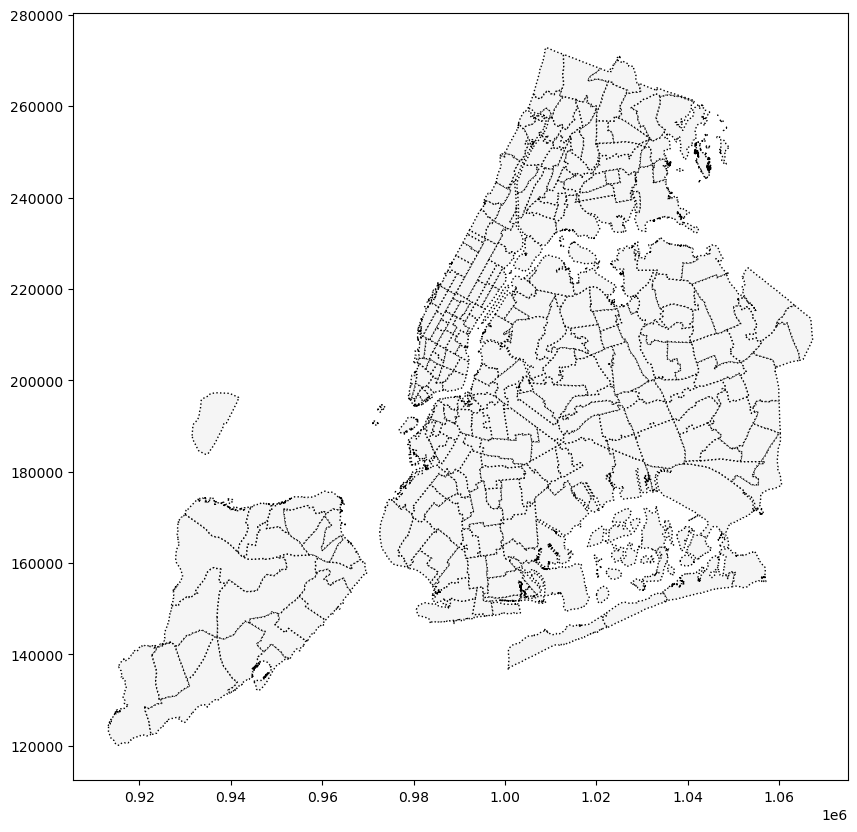

In [63]:
taxi_zones_shape.plot(figsize = (10,10), color = "whitesmoke", linestyle = ":", edgecolor = "black")
plt.show()

In [64]:
import folium

In [65]:
# Reproject to EPSG 4326 for folium
taxi_zones_folium = taxi_zones_shape.to_crs(epsg = 4326)

# Make base map centered on NYC
m = folium.Map(location = [40.7128, -74.0060], zoom_start = 11)

# Add polygons
folium.GeoJson(
    taxi_zones_folium,
    tooltip = folium.GeoJsonTooltip(fields = ["zone", "borough"])
).add_to(m)
m.save("../reports/maps/taxi_zones.html")

We seek to create two choropleths counting the both the number of pick up and drop off trips by zone

In [66]:
# Function to make a choropleth that counts the trips in each taxi zone, displaying a tooltip with: Zone, Borough, Trips, Service Zone, LocationID
def make_choropleth(df, count_col, geo_data, zone_lookup, extra):
    
    # Count trips in each zone
    trips_count = df[count_col].value_counts().reset_index()
    trips_count.columns = ["LocationID", "trips"]

    # Merge this into the orignal GeoPandasDataFrame so that we can use the trips count in the tooltip
    zones =  geo_data.merge(
        trips_count,
        left_on = "LocationID",
        right_on = "LocationID",
        how = "left"
    )

    # Fill missing trip counts with 0 
    zones["trips"] = zones["trips"].fillna(0)

    # We would also like to see the taxi service zone on the tooltip: Yellow, Green etc
    # To do this we will merge the taxi_zone_lookup onto zones as well
    service_zones = zone_lookup[["LocationID", "service_zone"]]

    zones = zones.merge(
        service_zones,
        left_on = "LocationID", 
        right_on = "LocationID",
        how = "left"
    )

    # Fill missing zones with "NA"
    zones["service_zone"] = zones["service_zone"].fillna("NA")

    # Create a base map
    m = folium.Map(location = [40.7128, -74.0060], zoom_start = 11)

    # Add a choropleth map to base map
    ch = folium.Choropleth(
        geo_data = zones,
        data = trips_count,
        columns = ["LocationID", "trips"],
        key_on = "feature.properties.LocationID",
        fill_color = "YlGnBu",
        legend_name = count_col + extra + " counts by zone"
        ).add_to(m)

    # Add hover tooltip to the choropleth's polygons
    folium.features.GeoJsonTooltip(
        fields = ["zone", "borough", "trips", "service_zone", "LocationID"],
        aliases = ["Zone:", "Borough:", "Trips:", "Service Zone:", "Location ID:"],
        sticky = False
    ).add_to(ch.geojson)

    # Return map
    return m

In [67]:
# Create pick up Choropleth
m_1 = make_choropleth(df, "PULocationID", taxi_zones_folium, taxi_zone_lookup, "")

# Export to HTML file
m_1.save("../reports/maps/PULocationID_count_by_zone.html")

# Create drop off Choropleth
m_2 = make_choropleth(df, "DOLocationID", taxi_zones_folium, taxi_zone_lookup, "")

# Export to HTML file
m_2.save("../reports/maps/DOLocationID_count_by_zone.html")

<Axes: xlabel='pickup_hour'>

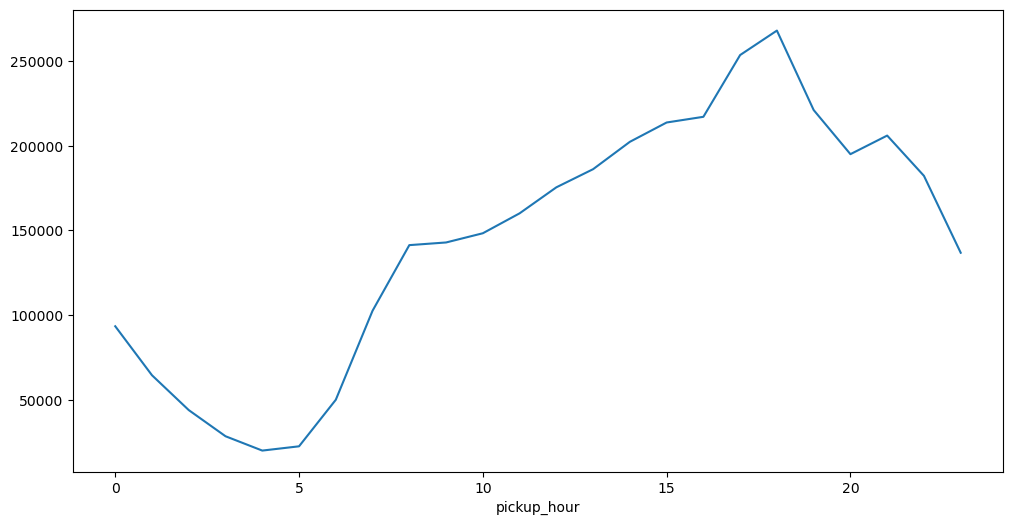

In [17]:
# Simple time series by hour
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

# trips per hour
hourly_trips = df.groupby('pickup_hour').size()

# Plot
hourly_trips.plot(figsize = (12,6))

<Axes: xlabel='dropoff_hour'>

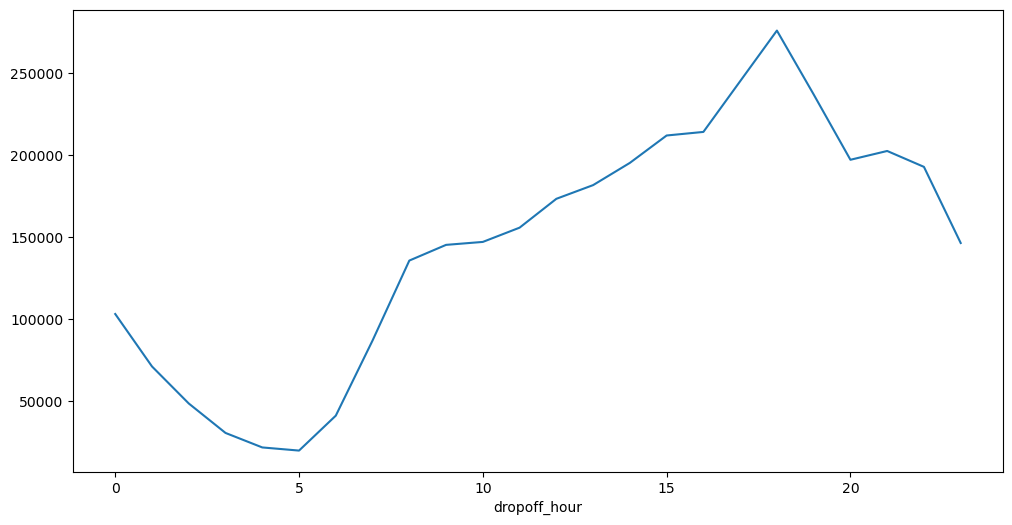

In [21]:
# Same time series for drop off
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

# Trips per hour
hourly_do = df.groupby('dropoff_hour').size()

# Plot
hourly_do.plot(figsize = (12,6))

<Axes: xlabel='pickup_date'>

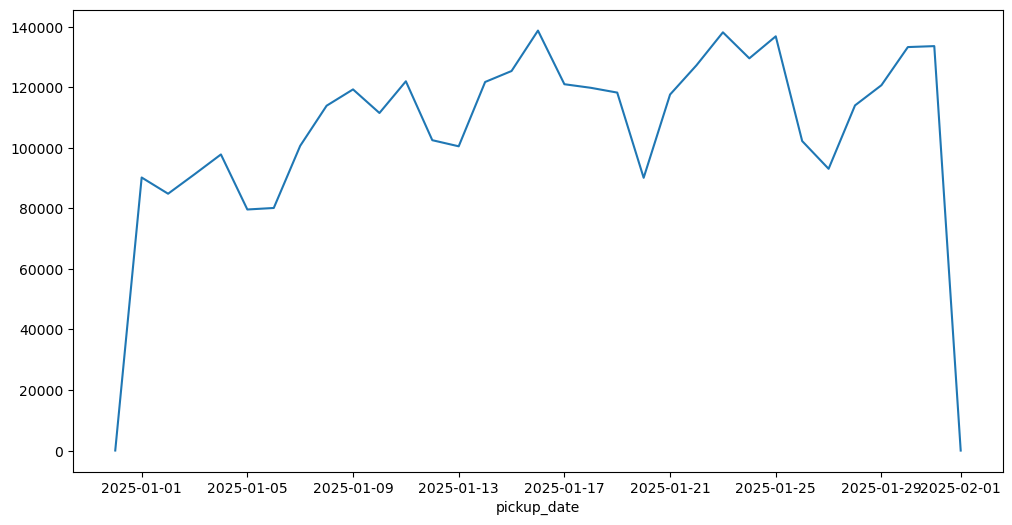

In [22]:
# Daily time series
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date

# Trips per day
daily_counts = df.groupby('pickup_date').size()

# Plot
daily_counts.plot(figsize = (12,6))

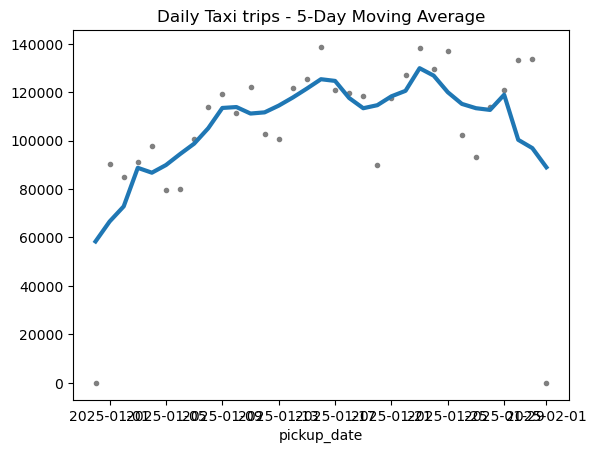

In [23]:
# Create rolling average
moving_average = daily_counts.rolling(
    window = 5,
    center = True,
    min_periods = 3,
).mean()

ax = daily_counts.plot(style = ".", color = "0.5")
moving_average.plot(
    ax = ax, linewidth = 3, title = "Daily Taxi trips - 5-Day Moving Average", legend = False,
);

In [8]:
# Load all the 2023 data
import glob

files_2023 = glob.glob("../data/raw/yellow_tripdata_2023*.parquet")

In [9]:
# Load and concatenate all the data into a single data frame:
df_2023 = pd.concat((pd.read_parquet(f) for f in files_2023), ignore_index = True)

In [10]:
df_2023.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,NaN
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,NaN
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,NaN
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,NaN
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,NaN


In [11]:
df_2023.shape

(38310226, 20)

In [12]:
# Number of missing values
df_2023.isna().sum()

VendorID                        0
tpep_pickup_datetime            0
tpep_dropoff_datetime           0
passenger_count           1309356
trip_distance                   0
RatecodeID                1309356
store_and_fwd_flag        1309356
PULocationID                    0
DOLocationID                    0
payment_type                    0
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           0
total_amount                    0
congestion_surcharge      1309356
airport_fee              35315203
Airport_fee               4304379
dtype: int64

<Axes: xlabel='pickup_date'>

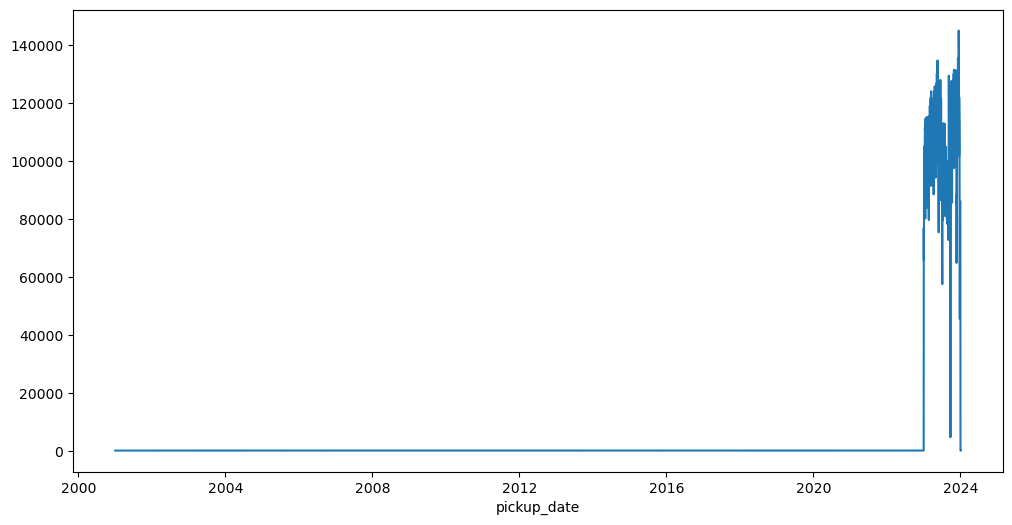

In [13]:
# Daily time series
df_2023['pickup_date'] = df_2023['tpep_pickup_datetime'].dt.date

# Trips per day
daily_counts_2023 = df_2023.groupby('pickup_date').size()

# Plot
daily_counts_2023.plot(figsize = (12,6))

In [14]:
df_2023[df_2023['tpep_pickup_datetime'] < '2023-01-01']

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee,pickup_date
80,2,2022-12-31 23:51:30,2022-12-31 23:56:06,1.0,0.86,1.0,N,141,140,1,...,1.00,0.5,2.00,0.00,1.0,13.50,2.5,0.0,NaN,2022-12-31
567,2,2022-12-31 23:59:37,2023-01-01 00:07:28,1.0,2.38,1.0,N,142,151,1,...,1.00,0.5,4.28,0.00,1.0,21.38,2.5,0.0,NaN,2022-12-31
761,2,2022-12-31 23:58:27,2023-01-01 00:02:21,1.0,0.49,1.0,N,229,237,1,...,1.00,0.5,0.08,0.00,1.0,10.88,2.5,0.0,NaN,2022-12-31
900,2,2022-12-31 23:44:31,2022-12-31 23:48:47,1.0,0.52,1.0,N,233,162,1,...,1.00,0.5,2.16,0.00,1.0,12.96,2.5,0.0,NaN,2022-12-31
1177,2,2022-12-31 23:59:25,2023-01-01 00:19:21,2.0,3.65,1.0,N,141,68,1,...,1.00,0.5,7.23,0.00,1.0,31.33,2.5,0.0,NaN,2022-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31380349,2,2008-12-31 23:04:45,2009-01-01 14:58:14,1.0,16.66,2.0,N,132,161,1,...,0.00,0.5,0.00,6.94,1.0,82.69,2.5,NaN,1.75,2008-12-31
32935036,2,2009-01-01 00:05:00,2009-01-01 00:13:17,1.0,1.58,1.0,N,236,238,2,...,0.00,0.5,0.00,0.00,1.0,14.00,2.5,NaN,0.00,2009-01-01
36062418,2,2002-12-31 22:16:54,2003-01-01 15:02:08,1.0,3.25,1.0,N,132,10,1,...,1.75,0.5,3.63,0.00,1.0,21.78,0.0,NaN,0.00,2002-12-31
37464864,2,2002-12-31 23:03:18,2003-01-01 21:09:44,1.0,28.19,2.0,N,132,13,1,...,0.00,0.5,16.54,6.94,1.0,99.23,2.5,NaN,1.75,2002-12-31


We notice that some of these rows have likely been included as the pickup is on 2022-12-31 and the drop off is on 2023-01-01.

However the rest appear to be irrelvant garbage values.

For consitency we will only look at taxi trips with a pickup in 2023.

In [15]:
df_2023 = df_2023[df_2023['tpep_pickup_datetime'].dt.year == 2023]

<Axes: xlabel='pickup_date'>

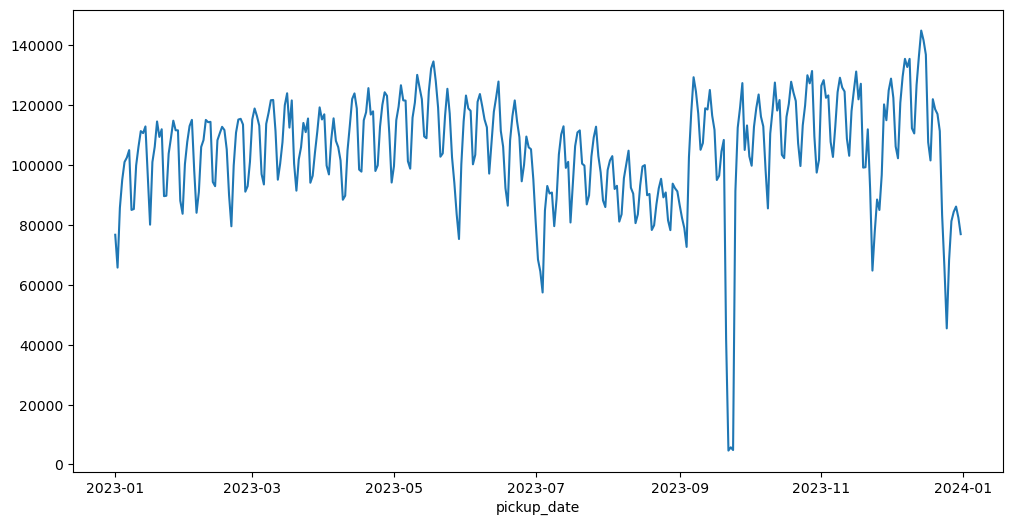

In [16]:
# Daily time series
df_2023['pickup_date'] = df_2023['tpep_pickup_datetime'].dt.date

# Trips per day
daily_counts_2023 = df_2023.groupby('pickup_date').size()

# Plot
daily_counts_2023.plot(figsize = (12,6))

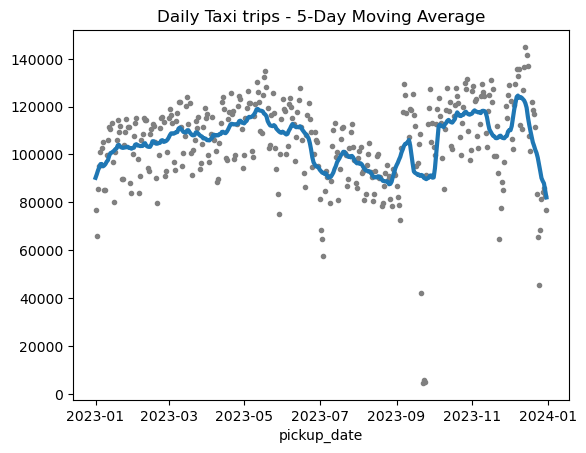

In [17]:
# Create rolling average
moving_average = daily_counts_2023.rolling(
    window = 20,
    center = True,
    min_periods = 5,
).mean()

ax = daily_counts_2023.plot(style = ".", color = "0.5")
moving_average.plot(
    ax = ax, linewidth = 3, title = "Daily Taxi trips - 5-Day Moving Average", legend = False,
);

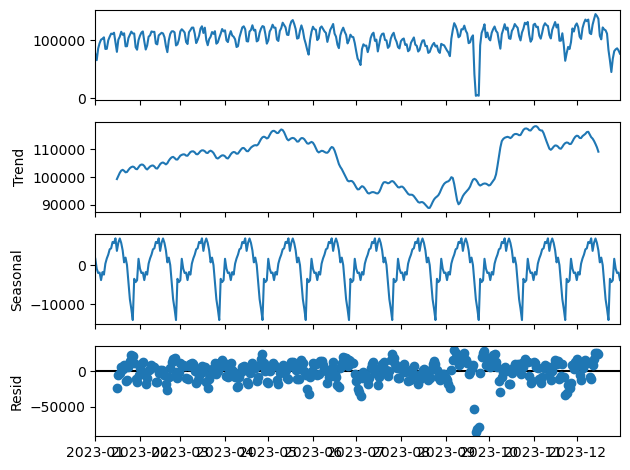

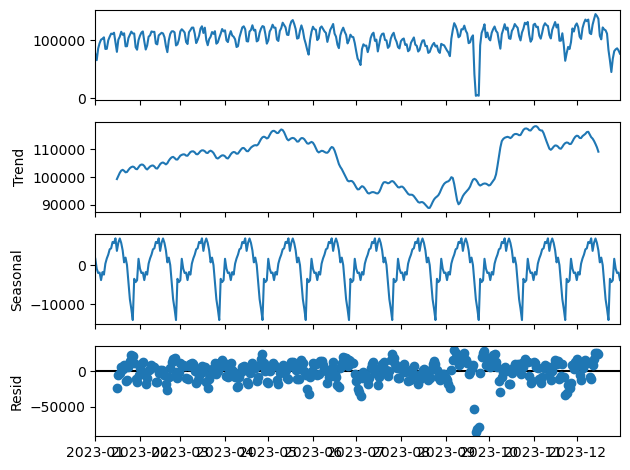

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Monthly seasonality
result = seasonal_decompose(daily_counts_2023, model = "additive", period = 30)
result.plot()

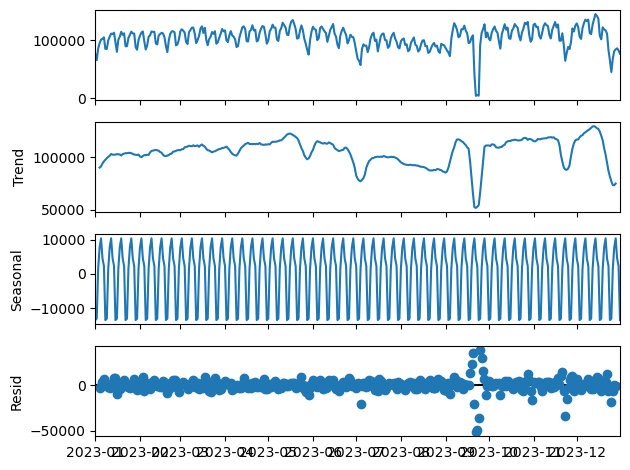

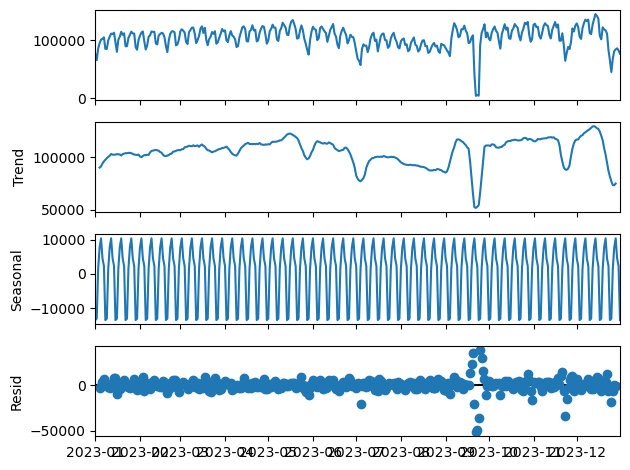

In [22]:
# Weekly seasonality
result = seasonal_decompose(daily_counts_2023, model = "additive", period = 7)
result.plot()

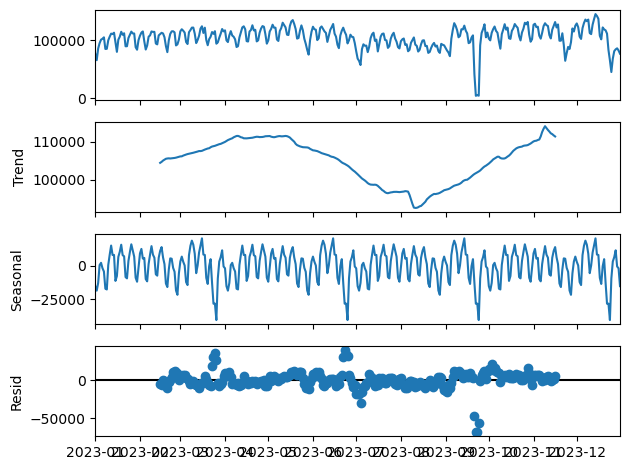

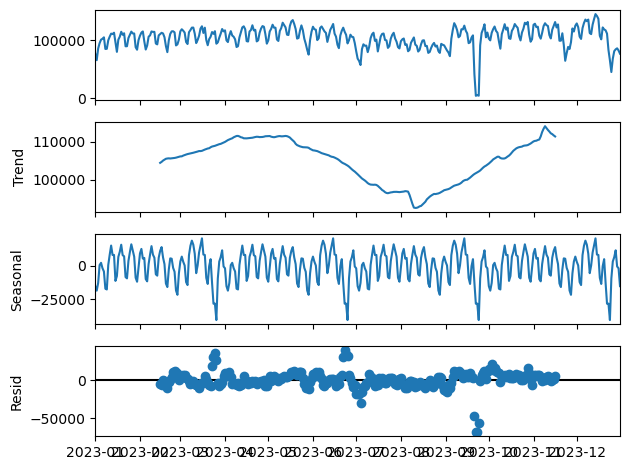

In [26]:
# Quartly seasonality
result = seasonal_decompose(daily_counts_2023, model = "additive", period = 91)
result.plot()

# This gives a trend that could potentially be a nice cubic polynomial

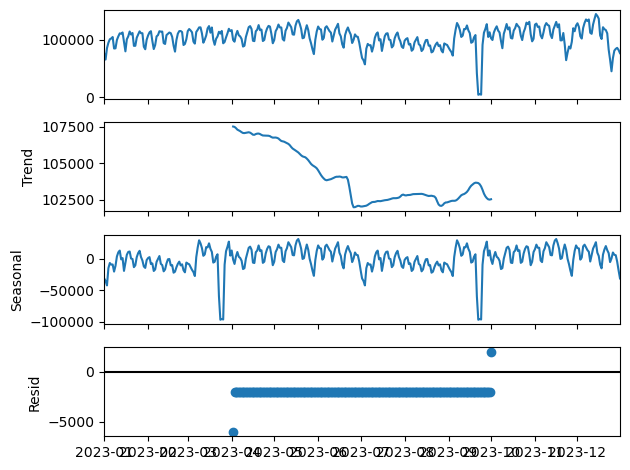

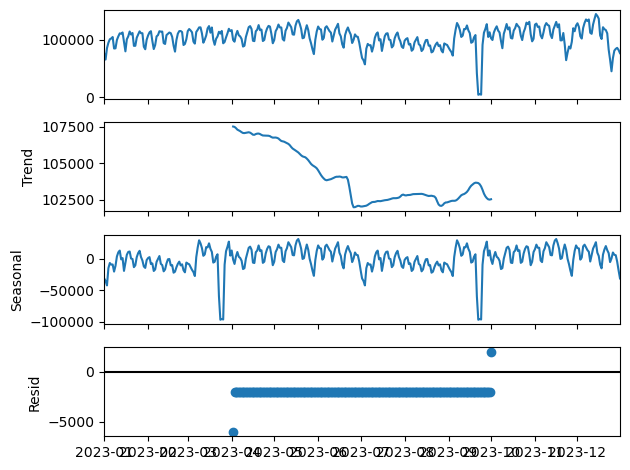

In [25]:
# Half annual seasonality
result = seasonal_decompose(daily_counts_2023, model = "additive", period = 182)
result.plot()

We will now explore some lag features.

In [28]:
# Create data frame with lags
y = daily_counts_2023
X = pd.DataFrame({
    "y": y,
    "lag_1": y.shift(1),
    "lag_7": y.shift(7),
    "lag_30": y.shift(30),
    "roll_7": y.shift(1).rolling(7).mean(),
    "roll_30": y.shift(1).rolling(30).mean()
}).dropna()

In [29]:
X.head() 

,y,lag_1,lag_7,lag_30,roll_7,roll_30
pickup_date,,,,,,
2023-01-31,100380,83768.0,103858.0,76752.0,103306.142857,98878.200000
2023-02-01,107780,100380.0,109196.0,65777.0,102809.285714,99665.800000
2023-02-02,113074,107780.0,114877.0,85783.0,102607.000000,101065.900000
2023-02-03,115149,113074.0,111668.0,95092.0,102349.428571,101975.600000
2023-02-04,98236,115149.0,111645.0,101063.0,102846.714286,102644.166667


In [30]:
corr = X.corr()

In [31]:
print(corr)

                y     lag_1     lag_7    lag_30    roll_7   roll_30
y        1.000000  0.776647  0.358629  0.094016  0.474880  0.280894
lag_1    0.776647  1.000000  0.277402  0.246902  0.600617  0.357562
lag_7    0.358629  0.277402  1.000000  0.048011  0.580572  0.485989
lag_30   0.094016  0.246902  0.048011  1.000000  0.143077  0.382583
roll_7   0.474880  0.600617  0.580572  0.143077  1.000000  0.605014
roll_30  0.280894  0.357562  0.485989  0.382583  0.605014  1.000000


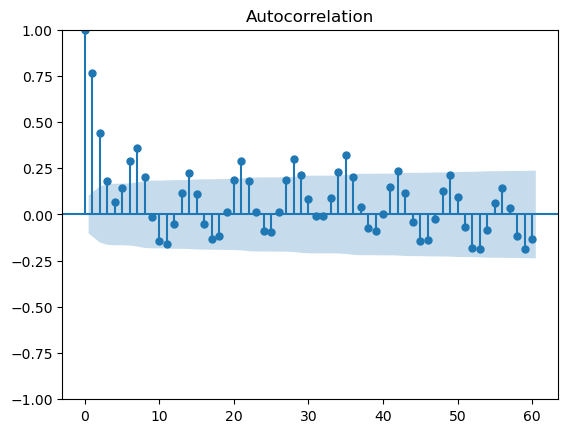

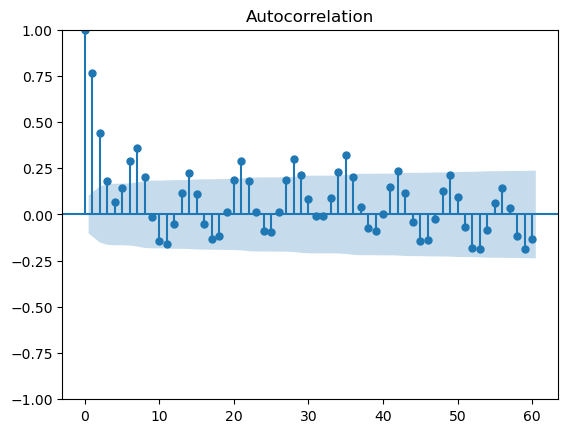

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y, lags = 60, alpha = 0.05)

In [44]:
from statsmodels.tsa.stattools import acf

# Compute autocorrelations
acf_vals, confint = acf(y, nlags = 60, alpha = 0.05)

In [50]:
# To find significant lags we look for lags where 0 lies outside the 95% confidence interval
significant_lags = []
for lag, (val, (low, high)) in enumerate(zip(acf_vals, confint)):
    if lag == 0:
        continue
    if 0 < low or 0 > high:
        significant_lags.append((lag, val))
print("Significant lags:", significant_lags)

Significant lags: [(1, np.float64(0.7662730712471214)), (2, np.float64(0.4425682759171072)), (3, np.float64(0.18253277264027853)), (6, np.float64(0.28744067673347545)), (7, np.float64(0.3603017906385654)), (8, np.float64(0.2029623333633374)), (14, np.float64(0.22319795409764911)), (21, np.float64(0.2916158667894344)), (28, np.float64(0.3001041134402277)), (29, np.float64(0.21587470206022352)), (34, np.float64(0.23126373141688283)), (35, np.float64(0.320365767251438)), (42, np.float64(0.23578956951021257))]


In [46]:
print(acf_vals)

[ 1.          0.76627307  0.44256828  0.18253277  0.06855361  0.14414553
  0.28744068  0.36030179  0.20296233 -0.01220075 -0.14324632 -0.15914832
 -0.0523789   0.11699968  0.22319795  0.11297454 -0.04997115 -0.13228247
 -0.11471653  0.01084888  0.1866639   0.29161587  0.1796744   0.01396873
 -0.09020688 -0.09724814  0.01098333  0.18585879  0.30010411  0.2158747
  0.08358355 -0.00875386 -0.00829662  0.08652756  0.23126373  0.32036577
  0.20041837  0.04084985 -0.07316275 -0.09036433  0.00509444  0.14938943
  0.23578957  0.11600499 -0.04122722 -0.14307528 -0.13807233 -0.02668482
  0.12749285  0.21196892  0.0958115  -0.06643306 -0.18042231 -0.1892704
 -0.08304406  0.06316253  0.14410994  0.03762243 -0.11451474 -0.18631704
 -0.13095166]


In [47]:
print(confint)

[[ 1.          1.        ]
 [ 0.66368387  0.86886227]
 [ 0.29129359  0.59384297]
 [ 0.01819517  0.34687037]
 [-0.09790409  0.23501131]
 [-0.02260904  0.31090011]
 [ 0.11937984  0.45550151]
 [ 0.18714416  0.53345942]
 [ 0.0220864   0.38383826]
 [-0.19545792  0.17105643]
 [-0.32651204  0.0400194 ]
 [-0.34358867  0.02529203]
 [-0.2382589   0.13350111]
 [-0.06903561  0.30303496]
 [ 0.03638985  0.41000605]
 [-0.07661943  0.30256852]
 [-0.24027231  0.14033001]
 [-0.32272168  0.05815674]
 [-0.30612035  0.0766873 ]
 [-0.18127719  0.20297495]
 [-0.00546862  0.37879642]
 [ 0.0975841   0.48564763]
 [-0.01891648  0.37826528]
 [-0.18632571  0.21426316]
 [-0.29051157  0.11009781]
 [-0.29797993  0.10348366]
 [-0.1902437   0.21221036]
 [-0.01537455  0.38709213]
 [ 0.09707218  0.50313605]
 [ 0.00822669  0.42352272]
 [-0.12641318  0.29358028]
 [-0.21910043  0.20159271]
 [-0.21864702  0.20205379]
 [-0.12382629  0.29688141]
 [ 0.02053562  0.44199184]
 [ 0.10698324  0.53374829]
 [-0.01796767  0.4188044 ]
 

We now switch to investigating exclusively JFK Airport

In [51]:
df_2023.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee,pickup_date
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,NaN,2023-01-01
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,NaN,2023-01-01
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,NaN,2023-01-01
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,NaN,2023-01-01
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,NaN,2023-01-01


In [72]:
df_jfk_2023 = df_2023[df_2023["PULocationID"] == 132].copy() 

In [73]:
df_jfk_2023.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee,pickup_date
21,1,2023-01-01 00:13:30,2023-01-01 00:44:00,1.0,17.80,2.0,N,132,116,1,...,1.25,0.5,15.85,6.55,1.0,95.15,0.0,1.25,NaN,2023-01-01
48,2,2023-01-01 00:41:41,2023-01-01 01:19:32,1.0,11.11,1.0,N,132,61,1,...,1.00,0.5,10.31,0.00,1.0,61.86,0.0,1.25,NaN,2023-01-01
59,2,2023-01-01 00:22:39,2023-01-01 01:30:45,1.0,16.02,1.0,N,132,265,2,...,1.00,0.5,0.00,0.00,1.0,64.85,0.0,1.25,NaN,2023-01-01
90,2,2023-01-01 00:37:44,2023-01-01 01:16:14,1.0,11.03,1.0,N,132,188,1,...,1.00,0.5,13.45,0.00,1.0,68.50,0.0,1.25,NaN,2023-01-01
91,2,2023-01-01 00:49:24,2023-01-01 01:30:59,1.0,13.54,1.0,N,132,149,1,...,1.00,0.5,12.86,0.00,1.0,78.41,0.0,1.25,NaN,2023-01-01


In [74]:
# Create drop off Choropleth for taxis from JFK
m_3 = make_choropleth(df_jfk_2023, "DOLocationID", taxi_zones_folium, taxi_zone_lookup, "JFK")

# Export to HTML file
m_3.save("../reports/maps/DOLocationID_JFK_count_by_zone.html")


In [75]:
df_jfk_2023.shape

(1992276, 21)

<Axes: xlabel='pickup_date'>

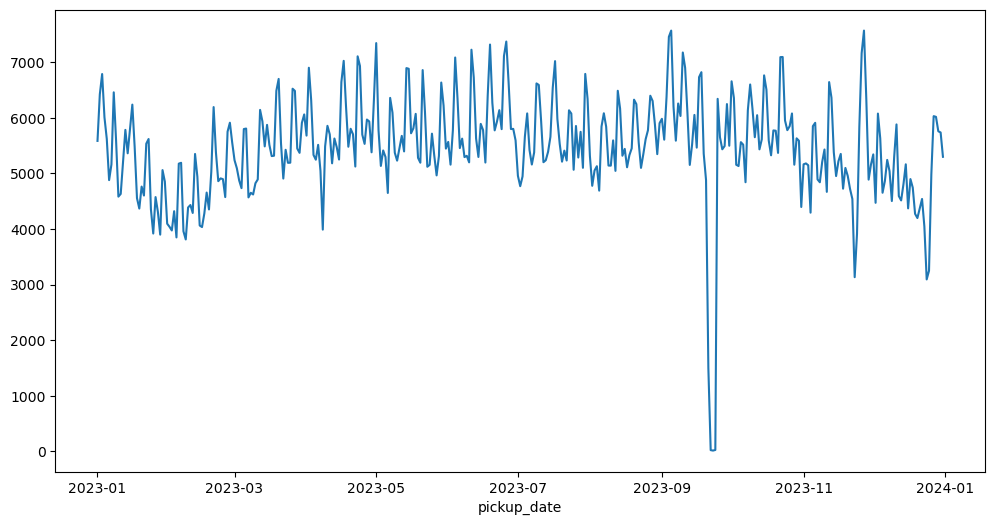

In [76]:
# Daily time series
df_jfk_2023['pickup_date'] = df_jfk_2023['tpep_pickup_datetime'].dt.date

# Trips per day
daily_counts_jfk_2023 = df_jfk_2023.groupby('pickup_date').size()

# Plot
daily_counts_jfk_2023.plot(figsize = (12,6))

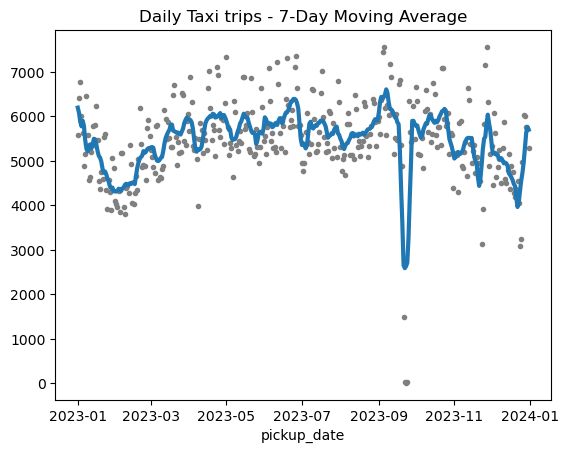

In [78]:
# Create rolling average
moving_average = daily_counts_jfk_2023.rolling(
    window = 7,
    center = True,
    min_periods = 3,
).mean()

ax = daily_counts_jfk_2023.plot(style = ".", color = "0.5")
moving_average.plot(
    ax = ax, linewidth = 3, title = "Daily Taxi trips - 7-Day Moving Average", legend = False,
);

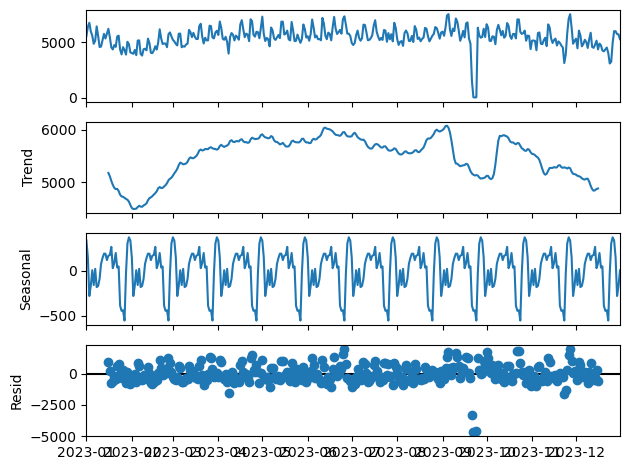

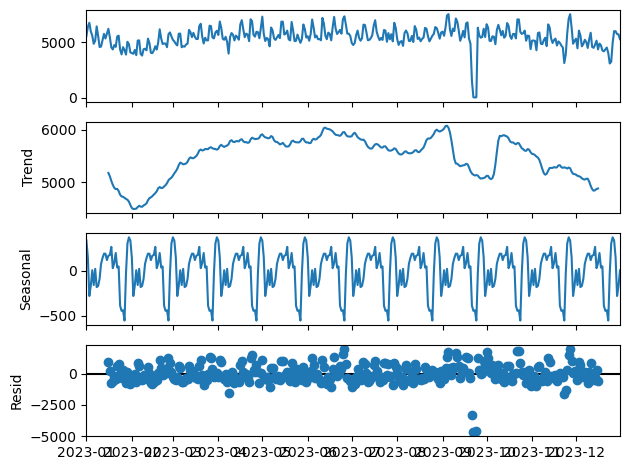

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Monthly seasonality
result = seasonal_decompose(daily_counts_jfk_2023, model = "additive", period = 30)
result.plot()

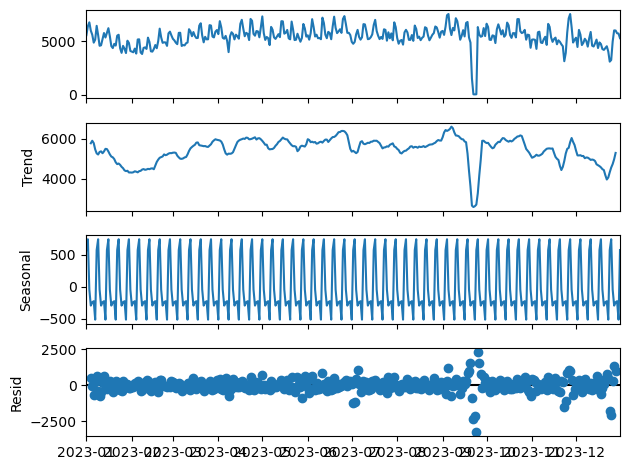

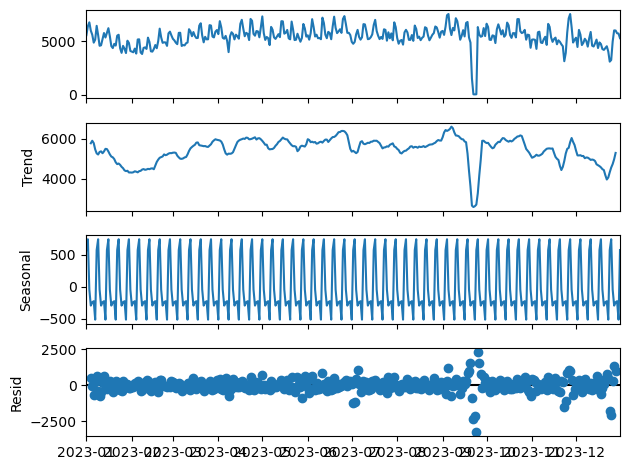

In [80]:
# Weekly seasonality
result = seasonal_decompose(daily_counts_jfk_2023, model = "additive", period = 7)
result.plot()

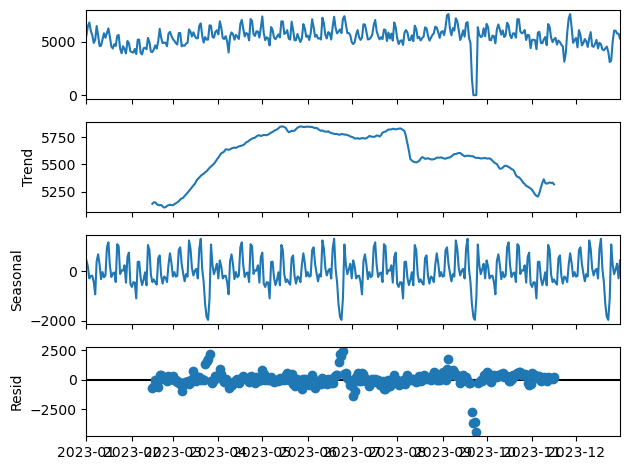

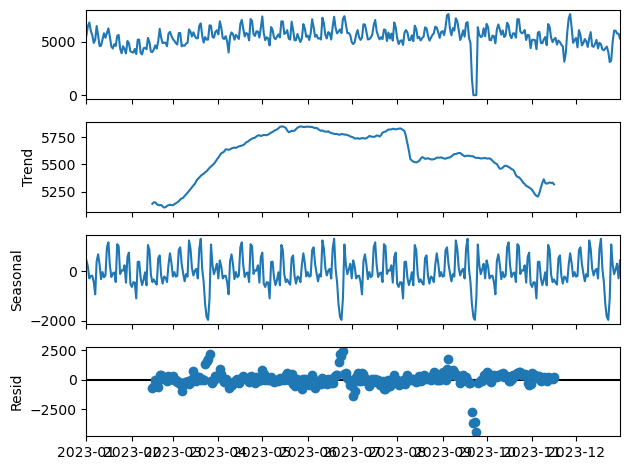

In [81]:
# Quartly seasonality
result = seasonal_decompose(daily_counts_jfk_2023, model = "additive", period = 91)
result.plot()

In [84]:
# Create data frame with lags
y = daily_counts_jfk_2023
X = pd.DataFrame({
    "y": y,
    "lag_1": y.shift(1),
    "lag_7": y.shift(7),
    "lag_30": y.shift(30),
    "roll_7": y.shift(1).rolling(7).mean(),
    "roll_30": y.shift(1).rolling(30).mean()
}).dropna()

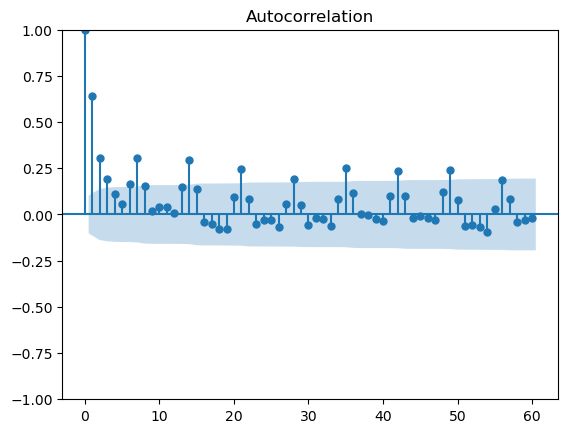

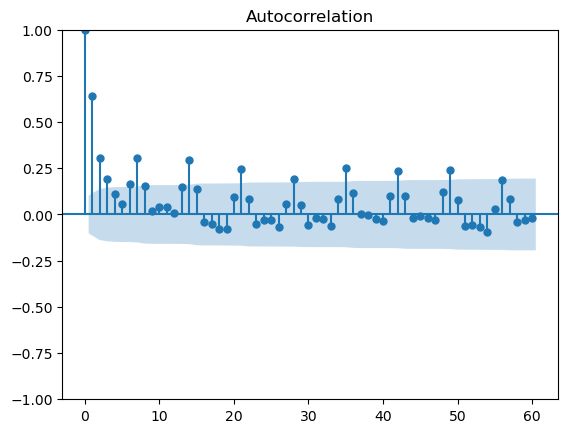

In [85]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y, lags = 60, alpha = 0.05)

In [87]:
from statsmodels.tsa.stattools import acf

# Compute autocorrelations
acf_vals, confint = acf(y, nlags = 60, alpha = 0.05)

In [88]:
# To find significant lags we look for lags where 0 lies outside the 95% confidence interval
significant_lags = []
for lag, (val, (low, high)) in enumerate(zip(acf_vals, confint)):
    if lag == 0:
        continue
    if 0 < low or 0 > high:
        significant_lags.append((lag, val))
print("Significant lags:", significant_lags)

# So sig lags are: 1, 2, 3, 6, 7, 14, 21, 28, 35, 42, 49

Significant lags: [(1, np.float64(0.6397971513975571)), (2, np.float64(0.30517227167380273)), (3, np.float64(0.19450060945839923)), (6, np.float64(0.1659349095654615)), (7, np.float64(0.30474743722785586)), (14, np.float64(0.29625350023606223)), (21, np.float64(0.24654585126870882)), (28, np.float64(0.19097383969914122)), (35, np.float64(0.25133271313461897)), (42, np.float64(0.23506973547245538)), (49, np.float64(0.2396271520285166))]


Based on the above we decided to create the following model.

If y is the number of daily pickups from JFK then we say that:

y = trend + seasonality + residuals

We are going to model the trend as being a roughly a cubic polynomial in time from the 7 day rolling average. 

We will use fourier features to capture what appears to be weekly seasonality.

Both of these will be fit under a linear regression model, we will then use XGBoost to fit the residuals using the lags as well as daily flight data.

In [156]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = daily_counts_jfk_2023

dp = DeterministicProcess(
    index = y.index,
    constant = True,   # Dummy feature for bias (y-intercept)
    order = 3,         # Polynomial trend (degree 3 = cubic)
    seasonal = True,    # Adds seasonal dummies
    period = 7,        # Weekly seasonality (7-day cycle)
    drop = True,       # Drop first column to avoid collinearity
)

X = dp.in_sample()


In [157]:
X

,const,trend,trend_squared,trend_cubed,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)"
pickup_date,,,,,,,,,,
2023-01-01,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-02,1.0,2.0,4.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0
2023-01-03,1.0,3.0,9.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0
2023-01-04,1.0,4.0,16.0,64.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-01-05,1.0,5.0,25.0,125.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,1.0,361.0,130321.0,47045881.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-12-28,1.0,362.0,131044.0,47437928.0,0.0,0.0,0.0,1.0,0.0,0.0
2023-12-29,1.0,363.0,131769.0,47832147.0,0.0,0.0,0.0,0.0,1.0,0.0


In [158]:
y

pickup_date
2023-01-01    5582
2023-01-02    6419
2023-01-03    6784
2023-01-04    6006
2023-01-05    5617
              ... 
2023-12-27    6027
2023-12-28    6014
2023-12-29    5755
2023-12-30    5733
2023-12-31    5296
Length: 365, dtype: int64

In [159]:
# We now add in the lag features.
# The reason we haven't used all the significant lags is we will need to drop the rows that
# contain null values and if we use lag say 49 we will be dropping about 15% of our data

for i in [1, 2, 3, 6, 7, 14]:
    X[f'y_lag_{i}'] = y.shift(i)

# Drop all na rows
mask = X.notna().all(axis=1) # keep only rows with no NaNs
X = X.loc[mask]
y = y.loc[mask]

In [160]:
X

,const,trend,trend_squared,trend_cubed,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",y_lag_1,y_lag_2,y_lag_3,y_lag_6,y_lag_7,y_lag_14
pickup_date,,,,,,,,,,,,,,,,
2023-01-15,1.0,15.0,225.0,3375.0,0.0,0.0,0.0,0.0,0.0,0.0,5359.0,5780.0,5210.0,5590.0,6455.0,5582.0
2023-01-16,1.0,16.0,256.0,4096.0,1.0,0.0,0.0,0.0,0.0,0.0,5798.0,5359.0,5780.0,4580.0,5590.0,6419.0
2023-01-17,1.0,17.0,289.0,4913.0,0.0,1.0,0.0,0.0,0.0,0.0,6234.0,5798.0,5359.0,4629.0,4580.0,6784.0
2023-01-18,1.0,18.0,324.0,5832.0,0.0,0.0,1.0,0.0,0.0,0.0,5474.0,6234.0,5798.0,5210.0,4629.0,6006.0
2023-01-19,1.0,19.0,361.0,6859.0,0.0,0.0,0.0,1.0,0.0,0.0,4553.0,5474.0,6234.0,5780.0,5210.0,5617.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,1.0,361.0,130321.0,47045881.0,0.0,0.0,1.0,0.0,0.0,0.0,4979.0,3248.0,3092.0,4368.0,4195.0,4512.0
2023-12-28,1.0,362.0,131044.0,47437928.0,0.0,0.0,0.0,1.0,0.0,0.0,6027.0,4979.0,3248.0,4538.0,4368.0,4804.0
2023-12-29,1.0,363.0,131769.0,47832147.0,0.0,0.0,0.0,0.0,1.0,0.0,6014.0,6027.0,4979.0,4044.0,4538.0,5161.0


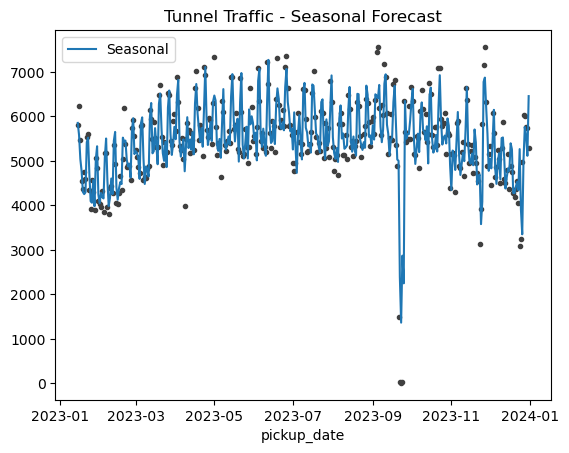

In [161]:
from sklearn.linear_model import LinearRegression


model = LinearRegression(fit_intercept = False)
_ = model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=y.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")

__ = ax.legend()

In [162]:
# We now train XGBoost on the residuals
from xgboost import XGBRegressor
# Create resiudals:
y_resid = y - y_pred

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X, y_resid)

# Add the predicted residuals onto the predicted trends
y_pred_boosted = xgb.predict(X) + y_pred

In [163]:
y_pred[0:5]

pickup_date
2023-01-15    5854.192698
2023-01-16    5580.075537
2023-01-17    5039.763694
2023-01-18    4762.968291
2023-01-19    4300.915621
dtype: float64

In [164]:
y_pred_boosted[0:5]

pickup_date
2023-01-15    5798.479739
2023-01-16    6233.028723
2023-01-17    5473.675621
2023-01-18    4553.753188
2023-01-19    4364.905539
dtype: float64

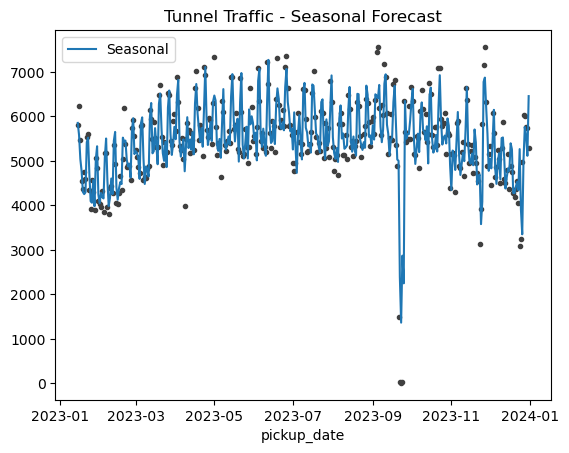

In [165]:
ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")

__ = ax.legend()

In [173]:
# To test the accuracy of this model we will use expanding window cross validation.
# The idea being that we train the data on an ever expanding window and test on the
# new unseen chunk.

# We will also compare against 3 Naive baselines:
# Today = yesterday
# Today = same weekday last week
# Today = average of last 7 days



from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

tscv = TimeSeriesSplit(n_splits = 5)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx].to_numpy(), X.iloc[test_idx].to_numpy()
    y_train, y_test = y.iloc[train_idx].to_numpy(), y.iloc[test_idx].to_numpy()

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_fit = model.predict(X_train)
    
    # Train XGBoost on residuals
    y_resid = y_train - y_fit

    xgb = XGBRegressor()
    xgb.fit(X_train, y_resid)

    # Add the predicted residuals onto the predicted trends
    y_fit_boosted = xgb.predict(X_train) + y_fit
    y_pred_boosted = xgb.predict(X_test) + y_pred
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Fold {fold+1}: MAE = {mae:.4f}")

    mae_boost = mean_absolute_error(y_test, y_pred_boosted)
    print(f"Fold {fold+1} Boosted MAE: MAE = {mae_boost:.2f}")

    # Now the simple baselines:

    # Today = yesterday
    y_pred_naive = y.shift(1).iloc[test_idx]
    mae_naive = mean_absolute_error(y_test, y_pred_naive)
    print(f"Fold {fold+1} Naive MAE: MAE = {mae_naive:.2f}")

    # Today = same weekday last week
    y_pred_seasonal = y.shift(7).iloc[test_idx]
    mae_seasonal = mean_absolute_error(y_test, y_pred_seasonal)
    print(f"Fold {fold+1} Seasonal MAE: MAE = {mae_seasonal:.2f}")
   
    # Rolling mean baseline
    y_pred_roll7 = y.shift(1).rolling(7).mean().iloc[test_idx]
    mae_roll_mean = mean_absolute_error(y_test, y_pred_roll7)
    print(f"Fold {fold+1} Roll mean MAE: MAE = {mae_roll_mean:.2f}")

    # XGBoost on all features
    xgb.fit(X_train, y_train)

    y_pred_xgb = xgb.predict(X_test)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    print(f"Fold {fold+1} XGB MAE: MAE = {mae_xgb:.2f}")
    print("\n")


Fold 1: MAE = 1755.8971
Fold 1 Boosted MAE: MAE = 1860.44
Fold 1 Naive MAE: MAE = 575.71
Fold 1 Seasonal MAE: MAE = 448.29
Fold 1 Roll mean MAE: MAE = 516.99
Fold 1 XGB MAE: MAE = 597.94


Fold 2: MAE = 1107.2936
Fold 2 Boosted MAE: MAE = 1085.38
Fold 2 Naive MAE: MAE = 581.60
Fold 2 Seasonal MAE: MAE = 582.69
Fold 2 Roll mean MAE: MAE = 576.56
Fold 2 XGB MAE: MAE = 438.18


Fold 3: MAE = 335.1809
Fold 3 Boosted MAE: MAE = 391.29
Fold 3 Naive MAE: MAE = 514.41
Fold 3 Seasonal MAE: MAE = 383.43
Fold 3 Roll mean MAE: MAE = 473.71
Fold 3 XGB MAE: MAE = 428.54


Fold 4: MAE = 684.5355
Fold 4 Boosted MAE: MAE = 680.94
Fold 4 Naive MAE: MAE = 707.72
Fold 4 Seasonal MAE: MAE = 1215.86
Fold 4 Roll mean MAE: MAE = 1048.97
Fold 4 XGB MAE: MAE = 766.07


Fold 5: MAE = 513.0087
Fold 5 Boosted MAE: MAE = 630.78
Fold 5 Naive MAE: MAE = 613.21
Fold 5 Seasonal MAE: MAE = 834.90
Fold 5 Roll mean MAE: MAE = 683.74
Fold 5 XGB MAE: MAE = 655.41




One of the problems we immediately notice is that the models MAE decreases and then later increases, this is likely due to the outliers we can see graphically from just after September. 

The above cells output is as follows:
Fold 1: MAE = 1755.8971
Fold 1 Boosted MAE: MAE = 1860.44
Fold 1 Naive MAE: MAE = 575.71
Fold 1 Seasonal MAE: MAE = 448.29
Fold 1 Roll mean MAE: MAE = 516.99
Fold 1 XGB MAE: MAE = 597.94


Fold 2: MAE = 1107.2936
Fold 2 Boosted MAE: MAE = 1085.38
Fold 2 Naive MAE: MAE = 581.60
Fold 2 Seasonal MAE: MAE = 582.69
Fold 2 Roll mean MAE: MAE = 576.56
Fold 2 XGB MAE: MAE = 438.18


Fold 3: MAE = 335.1809
Fold 3 Boosted MAE: MAE = 391.29
Fold 3 Naive MAE: MAE = 514.41
Fold 3 Seasonal MAE: MAE = 383.43
Fold 3 Roll mean MAE: MAE = 473.71
Fold 3 XGB MAE: MAE = 428.54


Fold 4: MAE = 684.5355
Fold 4 Boosted MAE: MAE = 680.94
Fold 4 Naive MAE: MAE = 707.72
Fold 4 Seasonal MAE: MAE = 1215.86
Fold 4 Roll mean MAE: MAE = 1048.97
Fold 4 XGB MAE: MAE = 766.07


Fold 5: MAE = 513.0087
Fold 5 Boosted MAE: MAE = 630.78
Fold 5 Naive MAE: MAE = 613.21
Fold 5 Seasonal MAE: MAE = 834.90
Fold 5 Roll mean MAE: MAE = 683.74
Fold 5 XGB MAE: MAE = 655.41

X

In [123]:
y

pickup_date
2023-01-01    5582
2023-01-02    6419
2023-01-03    6784
2023-01-04    6006
2023-01-05    5617
              ... 
2023-12-27    6027
2023-12-28    6014
2023-12-29    5755
2023-12-30    5733
2023-12-31    5296
Length: 365, dtype: int64

In [124]:
y.mean()

np.float64(5458.290410958904)